# Relativistic approximations of the Saha and Planck function in white dwarfs
 relatavstic statmechimcs in white dwarfs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.constants as c
import astropy.units as u
from astropy import table
from astropy.table import QTable
from tqdm import tqdm
from scipy.integrate import solve_bvp, odeint, solve_ivp
from scipy.integrate import odeint

import smplotlib

#### This verion of the $\mu$ is the boltzmann approximation withy no $\pm$ 1 

In [69]:
# T and n in log space 
T = np.logspace(10, 20, 100)
n = np.logspace(20, 30, 100)

A = c.h**3 *c.c**5 / (16*np.pi* c.k_B**3)
A = A.value
B = c.m_p**2 * c.c**4 
B = B.value



In [70]:
mu = np.log(A * n/T )*c.k_B.value*T  + B

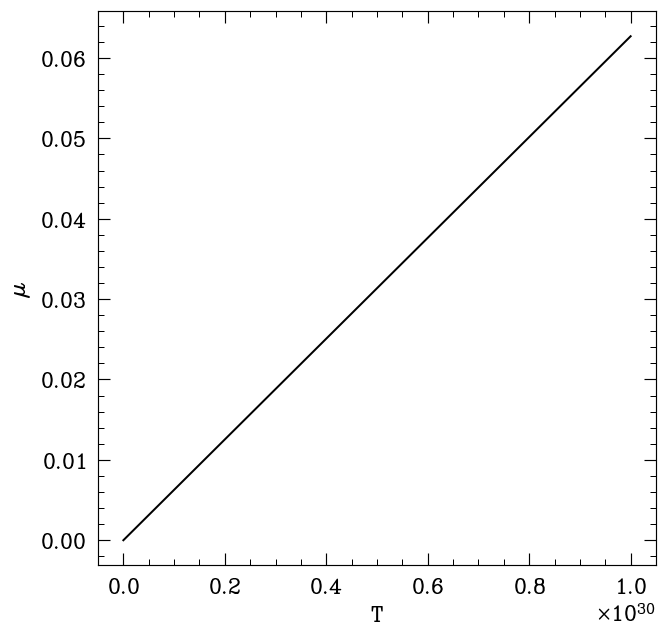

In [71]:
plt.plot(n, mu)

plt.xlabel('T')
plt.ylabel('$\mu$')
plt.show()


In [72]:
# version

n = np.logspace(20, 30, 100)
T = 100000 


A = (c.h**3 *c.c**5 * n) / (16*np.pi* (c.k_B*T)**3)
AA = np.log10(A.value) * c.k_B*T
AA = AA.cgs.value
BB = (c.m_p**2 * c.c**4).value - (c.m_p*c.c**2).value
BB = BB

mu_2 = AA + BB

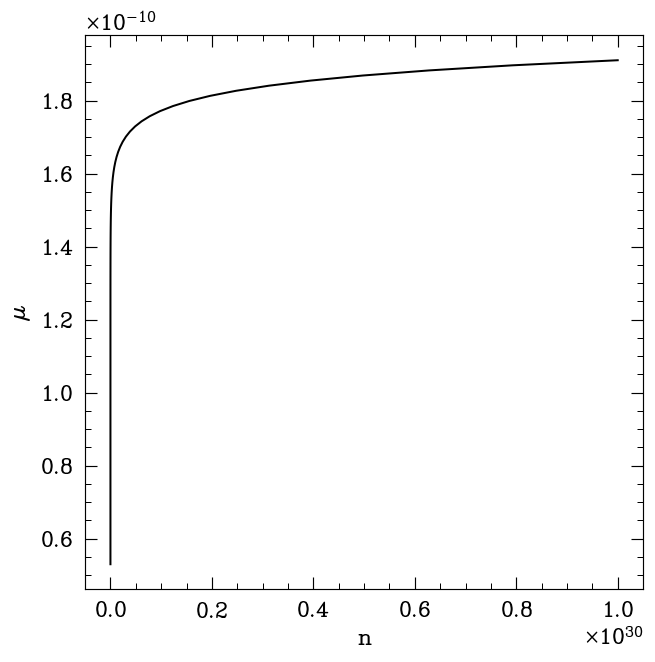

In [73]:
plt.plot(n, mu_2)


plt.xlabel('n')
plt.ylabel('$\mu$')
plt.show()


### Fermi-Dirac distribution of the electrons

# <center> $ n = \frac{8 \pi}{h^3} \int_0^\infty \frac{p^2 dp}{e^{ ( -\mu + mc^2\sqrt{1 + (p/mc)^2})/kT} + 1} $

In [74]:
# solve numerically the equation
# $ n = \frac{8 \pi}{h^3} \int_0^\infty \frac{p^2 dp}{e^{ ( -\mu + mc^2\sqrt{1 + (p/mc)^2})/kT} + 1} $

T = 100000
n = np.logspace(20, 30, 100)
def integrand(p, mu, T):
    AAA = (-mu + (c.m_p*c.c**2).value * np.sqrt(1 + (p/(c.m_p*c.c)).value**2)) / (c.k_B.value*T)
    exp = np.exp(AAA)
    return p**2 / (exp + 1)

def f(mu, T, n):
    return n - 8*np.pi/(c.h.value**3) * scipy.integrate.quad(integrand, 0, np.inf, args=(mu, T))[0]


# mu = scipy.optimize.brentq(f, -1e-10, 1e-10, args=(T, n[34]))

# use f solve to find mu
# mu = scipy.optimize.fsolve(f, 1e-10, args=(T, n[34]))

for i in np.logspace(10, 40, 100):
    #mu = scipy.optimize.fsolve(f, 442, args=(T, i))
    mu = scipy.optimize.brentq(f, 0.01, 1e50, args=(T, i))
    plt.plot(i, mu, 'o')

plt.xlabel('n')
plt.ylabel('$\mu$')

plt.show()


ValueError: f(a) and f(b) must have different signs

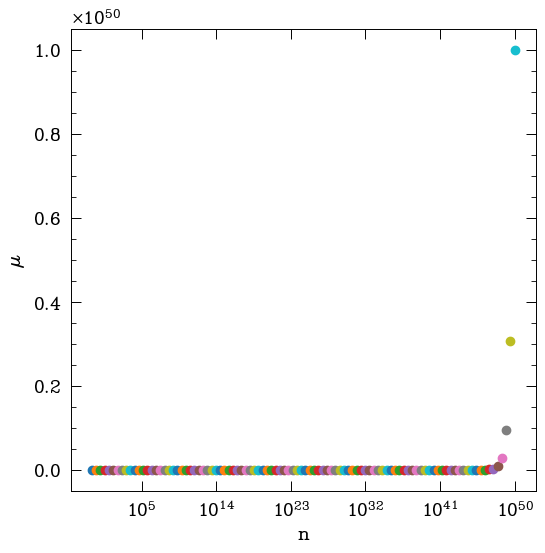

In [ ]:
# plot f as a function of n 
# for different T

for i in np.logspace(-1, 50, 100):
    plt.plot(i, f(1e-10, 1e5, i) , 'o')

plt.xlabel('n')
plt.ylabel('$\mu$')
plt.xscale('log')

plt.show()


In [ ]:
8*np.pi/(c.h**3)

<Quantity 8.63916505e+100 1 / (J3 s3)>

## Eric -- September 26th

In [ ]:
def idealElectronPressure(n_e, T):
    return n_e * c.k_B * T

# # TODO refactor the below function by defining each case as a separate function
# def fullyDegenElectronPressure_routine(n_e, mu_e, thresh):
#     """
#     Calculate the fully degenerate electron pressure as a function of electron density.
    
#     Parameters:
#         n_e (float): Electron number density. Must have units.
#         mu_e (float): Number of baryons per electron.
#         thresh (float): Relativity threshold.
    
#     Returns:
#         list: A list containing the electron number density, fully degenerate electron pressure, and the regime.
#     """
#     # Eqn 37 in Mike's notes
#     p_max = (3 * n_e * c.h**3 / 8 / np.pi)**(1/3)
    
#     # Non-relativistic case
#     if p_max < thresh * c.m_e * c.c:
#         # Eqn 43 in Mike's notes
#         P_e = c.h**2 / 60 / np.pi**(2/3) / c.m_e * (3 * n_e)**(5/3)
#         regime = 'NR'
        
#     # Extreme-relativistic case
#     elif thresh * p_max > c.m_e * c.c:
#         # Eqn 45 in Mike's notes
#         P_e = c.c * c.h / 24 / np.pi**(1/3) * (3 * n_e)**(4/3)
#         regime = 'ER'
        
#     # Intermediate densities
#     else:
#         # Eqn 47 in Mike's notes
#         y = (p_max / c.m_e / c.c).si
#         P_e = np.pi * c.m_e**4 * c.c**5 / 3 / c.h**3 * (y * (1 + y**2)**(1/2) * (2 * y**2 - 3) + 3 * np.arcsinh(y).value)
#         regime = 'IN'
    
#     # Note, if changing units here, update units parameter in fullyDegenElectronPressure for the QTable
#     return [n_e.si, P_e.si, regime]

def fullyDegenElectronPressure_routine(n_e, mu_e, thresh):
    # Eqn 37 in Mike's notes
    p_max = (3 * n_e * c.h**3 / 8 / np.pi)**(1/3)
    
    if p_max < thresh * c.m_e * c.c:
        return calculate_non_relativistic_pressure_routine(n_e)
    elif thresh * p_max > c.m_e * c.c:
        return calculate_extreme_relativistic_pressure_routine(n_e)
    else:
        return calculate_intermediate_pressure_routine(n_e, p_max)
    
def calculate_non_relativistic_pressure_routine(n_e):
    # Eqn 43 in Mike's notes
    P_e = c.h**2 / 60 / np.pi**(2/3) / c.m_e * (3 * n_e)**(5/3)
    regime = 'NR'
    return [n_e.si.value, P_e.si.value, regime]

def calculate_extreme_relativistic_pressure_routine(n_e):
    # Eqn 45 in Mike's notes
    P_e = c.c * c.h / 24 / np.pi**(1/3) * (3 * n_e)**(4/3)
    regime = 'ER'
    return [n_e.si.value, P_e.si.value, regime]

def calculate_intermediate_pressure_routine(n_e, p_max):
    # Eqn 47 in Mike's notes
    y = (p_max / c.m_e / c.c).si
    P_e = np.pi * c.m_e**4 * c.c**5 / 3 / c.h**3 * (y * (1 + y**2)**(1/2) * (2 * y**2 - 3) + 3 * np.arcsinh(y).value)
    regime = 'IN'
    return [n_e.si.value, P_e.si.value, regime]

def fullyDegenElectronPressure(n_e, mu_e=2, thresh=0.001):
    # Check if input has multiple values (numpy array, list, etc.)
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            output.append(fullyDegenElectronPressure_routine(n, mu_e, thresh))
        
    else:
        output = fullyDegenElectronPressure_routine(n_e, mu_e, thresh)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})
    
def calculate_extreme_relativistic_pressure(n_e):
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            output.append(calculate_extreme_relativistic_pressure_routine(n))
        
    else:
        output = calculate_extreme_relativistic_pressure_routine(n_e)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})

def calculate_non_relativistic_pressure(n_e):
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            output.append(calculate_non_relativistic_pressure_routine(n))
        
    else:
        output = calculate_non_relativistic_pressure_routine(n_e)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})

def calculate_intermediate_pressure(n_e):
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        
        # Calculate pressure for each value of n_e
        for i, n in enumerate(n_e):
            p_max = (3 * n * c.h**3 / 8 / np.pi)**(1/3)
            output.append(calculate_intermediate_pressure_routine(n, p_max))
        
    else:
        output = calculate_intermediate_pressure_routine(n_e, p_max)
    
    # Create QTable with appropriate units and dtype
    return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'],
                    units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'],
                    meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})
    

In [ ]:
fullyDegenElectronPressure(10**200 / u.cm ** 3)

n_e,P_e,regime
1 / m3,N / m2,
float64,float64,bytes2
9.999999999999999e+205,1.1349512461656704e+249,ER


In [ ]:
number_density_range = np.logspace(1, 50, 100) / u.cm ** 3

fullyDegenElectronPressure(number_density_range)

n_e,P_e,regime
1 / m3,N / m2,
float64,float64,bytes2
9999999.999999998,1.0846942108064506e-26,NR
31257158.496882364,7.248082820449793e-26,NR
97700995.72992256,4.843273251457737e-25,NR
305385550.88334155,3.236344888623982e-24,NR
954548456.6618346,2.162572230458013e-23,NR
2983647240.28334,1.4450618870649993e-22,NR
9326033468.8322,9.656111495548038e-22,NR
29150530628.251816,6.452352667319449e-21,NR


In [ ]:
# Define our three regimes
# TODO figure our what the threshold should be to demarcate the three regimes

NR_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'NR']
ER_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'ER']
IN_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'IN']

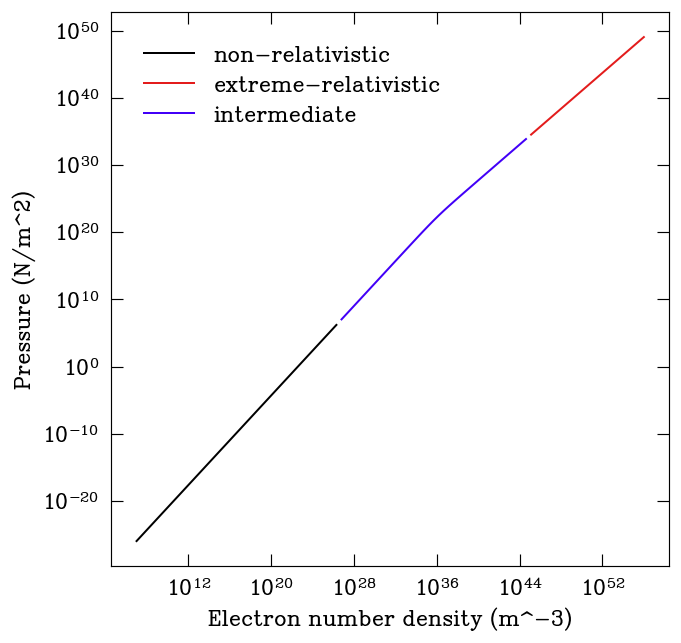

In [ ]:
# Plot the three regimes as different colors
fig, ax = plt.subplots()

ax.plot(NR_reg['n_e'], NR_reg['P_e'], label='non-relativistic')
ax.plot(ER_reg['n_e'], ER_reg['P_e'], label='extreme-relativistic')
ax.plot(IN_reg['n_e'], IN_reg['P_e'], label='intermediate')

ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
ax.set_ylabel('Pressure (N/m^2)')
ax.set_xlabel('Electron number density (m^-3)')
plt.show()

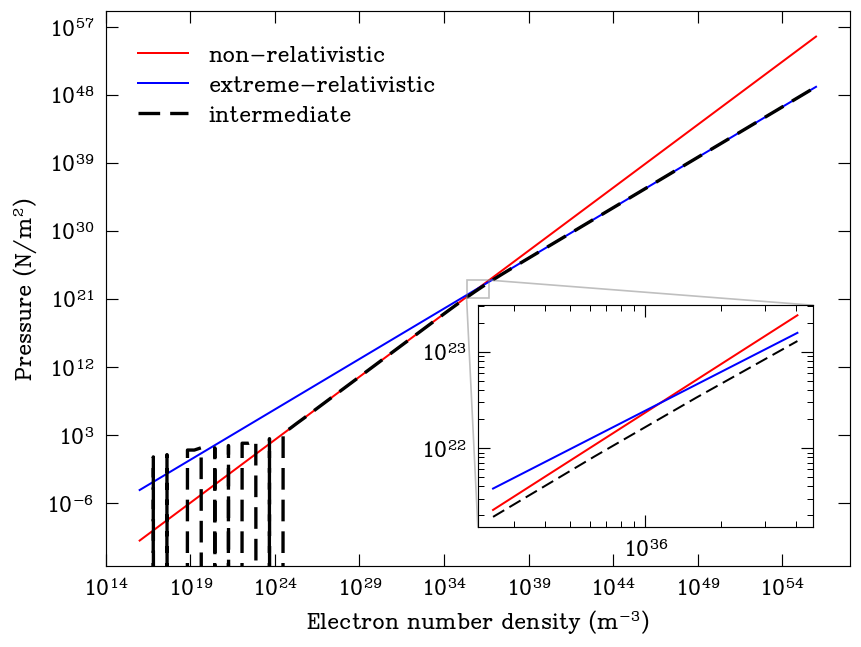

In [ ]:
# Now redefine the threshold to overlay the three different cases over each other for the entire ranges

number_density_range = np.logspace(10, 50, 100) / u.cm ** 3
    
NR_reg_full = calculate_non_relativistic_pressure(number_density_range)
ER_reg_full = calculate_extreme_relativistic_pressure(number_density_range)
IN_reg_full = calculate_intermediate_pressure(number_density_range)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(NR_reg_full['n_e'], NR_reg_full['P_e'], label='non-relativistic', c='r')
ax.plot(ER_reg_full['n_e'], ER_reg_full['P_e'], label='extreme-relativistic', c='b')
ax.plot(IN_reg_full['n_e'], IN_reg_full['P_e'], label='intermediate', c='k', ls='--', lw=2)

# ax.set_xlim(10**28, 10**32)
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
ax.set_ylabel(r'Pressure $(N/m^2)$')
ax.set_xlabel(r'Electron number density $(m^{-3})$')

# Inset axes and indicate zoom
axins = ax.inset_axes((0.5, 0.07, 0.45, 0.4))
axins.plot(NR_reg_full['n_e'][(NR_reg_full['n_e']>=10**35 / u.m ** 3) & (NR_reg_full['n_e']<=10**37 / u.m ** 3)], NR_reg_full['P_e'][(NR_reg_full['n_e']>=10**35 / u.m ** 3) & (NR_reg_full['n_e']<=10**37 / u.m ** 3)], label='non-relativistic', c='r')
axins.plot(ER_reg_full['n_e'][(ER_reg_full['n_e']>=10**35 / u.m ** 3) & (ER_reg_full['n_e']<=10**37 / u.m ** 3)], ER_reg_full['P_e'][(ER_reg_full['n_e']>=10**35 / u.m ** 3) & (ER_reg_full['n_e']<=10**37 / u.m ** 3)], label='extreme-relativistic', c='b')
axins.plot(IN_reg_full['n_e'][(IN_reg_full['n_e']>=10**35 / u.m ** 3) & (IN_reg_full['n_e']<=10**37 / u.m ** 3)], IN_reg_full['P_e'][(IN_reg_full['n_e']>=10**35 / u.m ** 3) & (IN_reg_full['n_e']<=10**37 / u.m ** 3)], label='intermediate', c='k', ls='--')
axins.set_yscale('log')
axins.set_xscale('log')
# axins.set_xticklabels([])
# axins.set_yticklabels([])

ax.indicate_inset_zoom(axins)

plt.show()

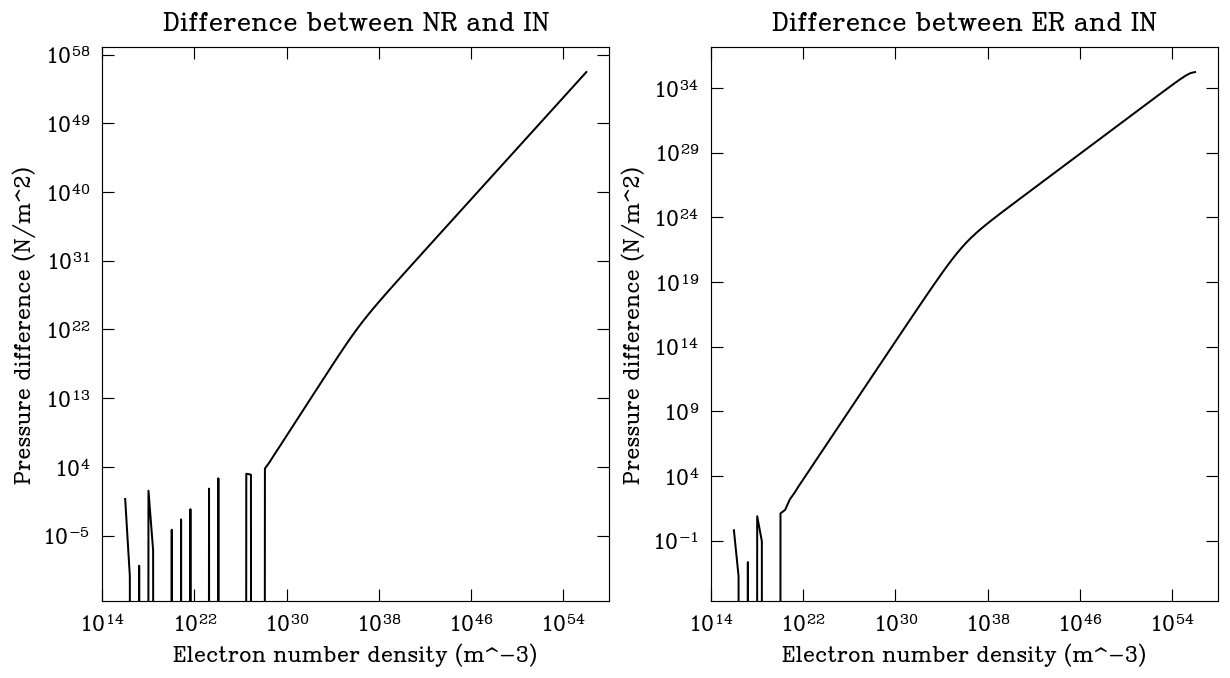

In [ ]:
# Now plot the difference between the three cases over the range
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].plot(NR_reg_full['n_e'], (NR_reg_full['P_e'] - IN_reg_full['P_e']), label='non-rel - intermediate')
ax[1].plot(ER_reg_full['n_e'], (ER_reg_full['P_e'] - IN_reg_full['P_e']), label='extreme-rel - intermediate')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel('Electron number density (m^-3)')
ax[0].set_ylabel('Pressure difference (N/m^2)')
ax[1].set_xlabel('Electron number density (m^-3)')
ax[1].set_ylabel('Pressure difference (N/m^2)')
ax[0].set_title('Difference between NR and IN')
ax[1].set_title('Difference between ER and IN')
plt.show()

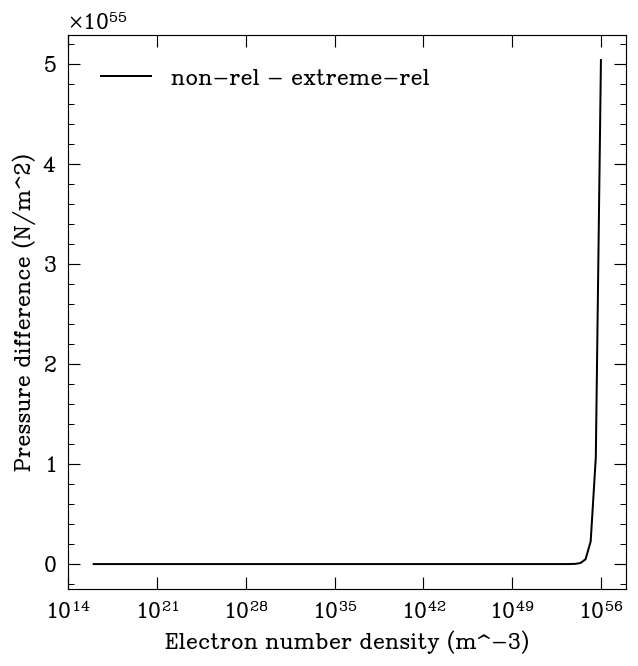

In [ ]:
# Plot the difference between the non-relativistic and extreme-relativistic cases
plt.subplots()
plt.plot(NR_reg_full['n_e'], NR_reg_full['P_e'] - ER_reg_full['P_e'], label='non-rel - extreme-rel')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlabel('Electron number density (m^-3)')
plt.ylabel('Pressure difference (N/m^2)')
plt.show()

In [ ]:
# What number densities do the boundaries of each regime correspond to?
central_value = 8*np.pi / 3 * (c.m_e * c.c/c.h) ** 3
central_value.si

<Quantity 5.8651566e+35 1 / m3>

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: nan 
Maximum boundary residual: 9.37e+09


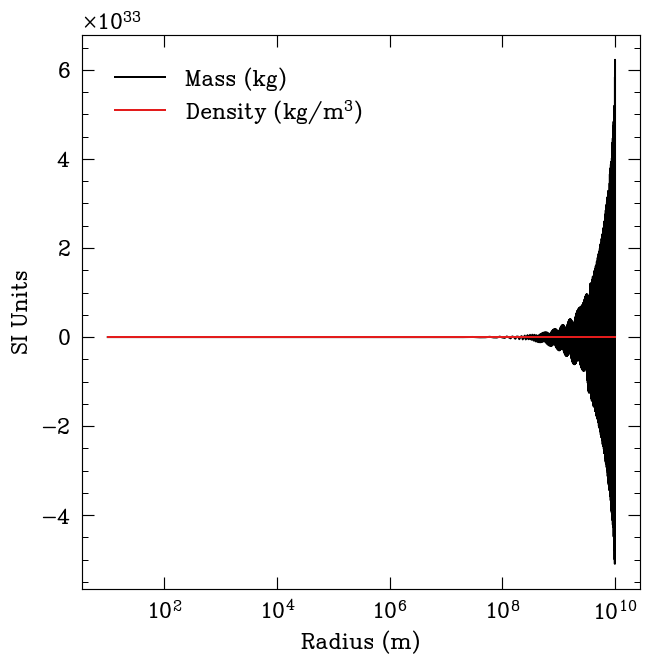

In [82]:
# Now we want to use our electron presure code to actually compute the inner structure of a WD for a range of masses up to the Chandrasekhar limit. We use a polytropic model

# Define your differential equations drho/dr and dm/dr as functions
max_mass = 1.44 * c.M_sun

def drhodr(r, rho, m, mu_e = 2):
    K_NR = c.h**2 / 5 / c.m_e * (3 / 8 / np.pi)**(2/3)
    return (- 3/5 * (c.G * (c.m_p + c.m_e)**(5/3) * mu_e**(5/3) * m * rho**(1/3)) / (K_NR * r**2)).si.value

def dmdr(r, rho):
    return (4 * np.pi * r**2 * rho)

def system(r, y):
    return np.array([drhodr(r, y[0], y[1]), dmdr(r, y[0])])

def bc(ya, yb):
    return np.array([ya[0]-1e7, yb[1]-max_mass.to(u.kg).value])

r_span = np.linspace(1e1, 1e10, 1000)

# Initialise array for the initial guess. Make the mass profile (second column) a linear function from 0 to the max_mass. Make the pressure profile a linear function from 10**10 to 0
y0 = np.zeros((2, r_span.size))
y0[0] = np.linspace(10**10, 0, r_span.size)
y0[1] = np.linspace(0, max_mass.to(u.kg).value, r_span.size)

sol = solve_bvp(system, bc, r_span, y0, verbose=2, bc_tol=1e2, tol=1e2)

plt.plot(sol.x, sol.y[1])
plt.plot(sol.x, sol.y[0])
# plt.yscale('log')
plt.xscale('log')
plt.legend([r'Mass (kg)', r'Density (kg/m$^3$)'])
plt.xlabel('Radius (m)')
plt.ylabel('SI Units')
# Make explicit x ticks on the defined radius max and min
# plt.xticks([1e2, 1e5, 1e10], ['100', '10$^{5}$', '10$^{10}$'])
plt.show()


In [ ]:
sol

       message: A singular Jacobian encountered when solving the collocation system.
       success: False
        status: 2
             x: [ 1.000e+02  1.001e+07 ...  9.990e+09  1.000e+10]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x0000020A6B80F680>
             p: None
             y: [[ 9.443e+09  9.216e+09 ...  9.318e+06 -6.209e+00]
                 [ 0.000e+00 -1.455e+30 ...  6.157e+33  2.863e+30]]
            yp: [[-0.000e+00  3.907e+02 ... -1.666e-01        nan]
                 [ 1.187e+15  1.160e+25 ...  1.169e+28 -7.803e+21]]
 rms_residuals: [ 5.372e+00  1.676e+00 ...  1.245e+00        nan]
         niter: 1

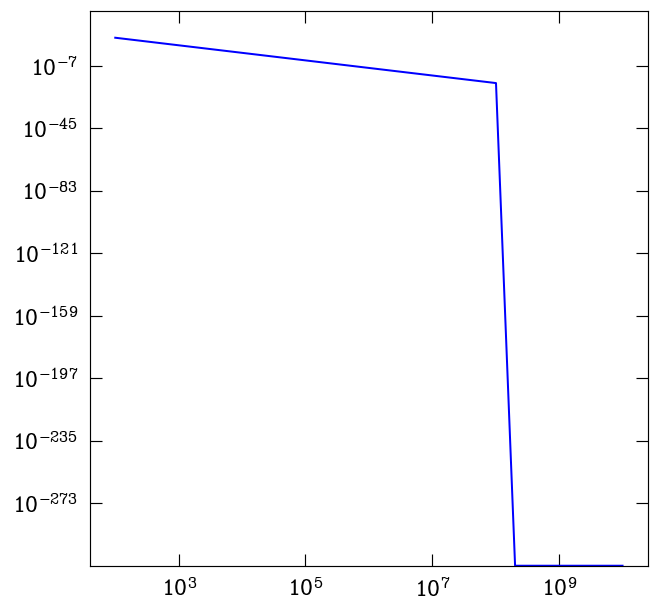

In [ ]:
# Try and do it usign the equation I derived.

def new_system(y, r, mu_e=2):
    rho, gamma = y
    K_NR = c.h**2 / 5 / c.m_e * (3 / 8 / np.pi)**(2/3)
    dydt = [gamma, (1/3)* rho**(-1) * gamma**2 - 2 * gamma / r - (12 * np.pi * c.G.value * (c.m_p.value + c.m_e.value)**(5/3) * mu_e**(5/3)) / (5 * K_NR.value) * rho**(4/3)]
    return dydt
    
y0 = [1e10, 0]

r = np.linspace(1e2, 1e10, 100)

sol = odeint(new_system, y0, r)

plt.plot(r, sol[:, 0], 'b', label='rho(r)')
plt.xscale('log')
plt.yscale('log')

16355it [05:27, 49.99it/s]


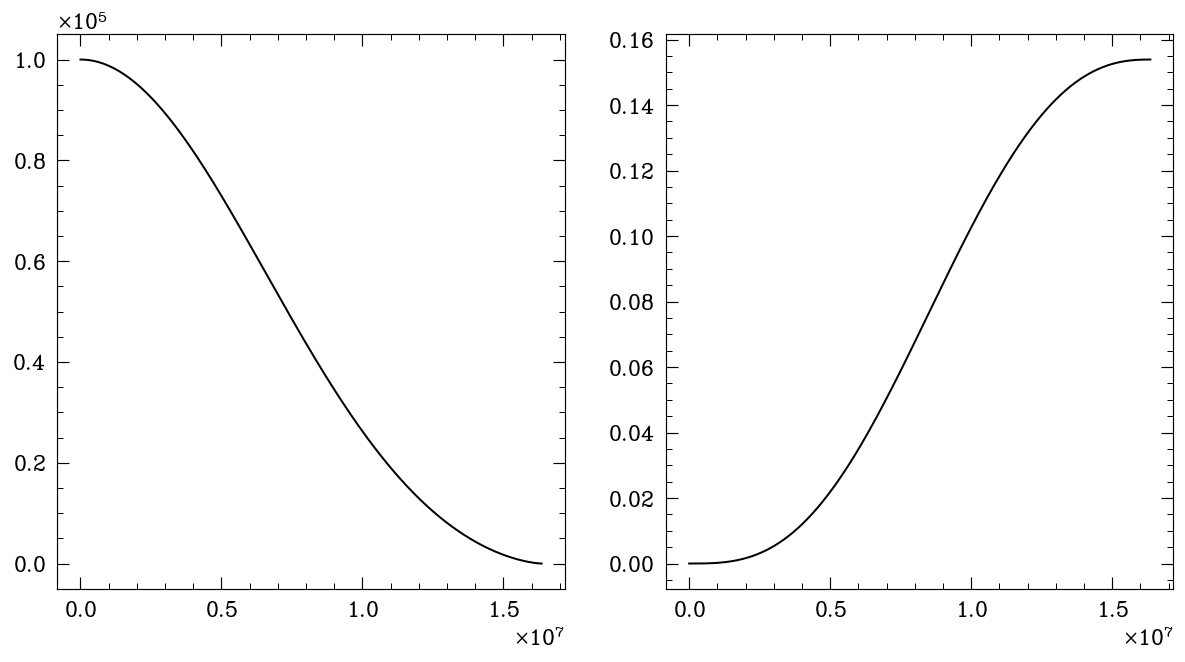

In [ ]:
# Fuck it, lets do it manually.

m_init = 0 * u.M_sun
rho_init = 1e5 * u.g/u.cm**3

r_start = 0.1 * u.m
r_step = 1e3 * u.m

max_mass = 5 * u.M_sun

mass = [m_init]
radius = [r_start]
dens = [rho_init]

def drhodr(r, rho, m, mu_e = 2):
    K_NR = c.h**2 / 5 / c.m_e * (3 / 8 / np.pi)**(2/3)
    return (- 3/5 * (c.G * (c.m_p + c.m_e)**(5/3) * mu_e**(5/3) * m * rho**(1/3)) / (K_NR * r**2)).cgs

def dmdr(r, rho):
    return (4 * np.pi * r**2 * rho)

def generator():
    while mass[-1] <= max_mass.cgs:
        yield

# while mass[-1] <= max_mass.cgs:
for _ in tqdm(generator()): # Gives a progress tracker
    mass_del = r_step * dmdr(radius[-1], dens[-1])
    dens_del = r_step * drhodr(radius[-1],dens[-1],mass[-1])
    
    mass.append((mass_del + mass[-1]).cgs)
    dens.append((dens_del + dens[-1]).cgs)
    radius.append((r_step + radius[-1]).cgs)
    
# Convert to astropy table
results_tab = QTable([radius, mass, dens], names=('r', 'm', 'rho'))

fig, ax  = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].plot(results_tab['r'],results_tab['rho'])
ax[1].plot(results_tab['r'],results_tab['m'])
plt.show()


609it [00:10, 56.52it/s]


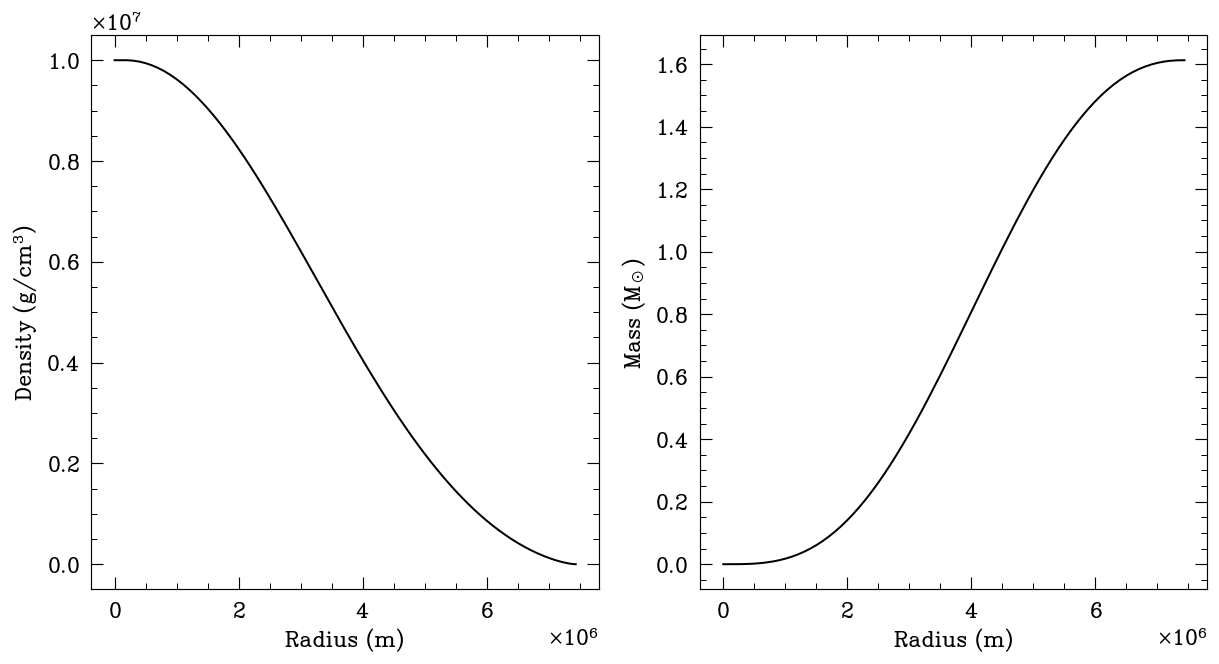

In [ ]:
# Use a dynamic radius step to prevent negative densities

m_init = 0 * u.M_sun
rho_init = 1e7 * u.g/u.cm**3

r_start = 0.1 * u.m
r_step = 1e5 * u.m

max_mass = 5 * u.M_sun

mass = [m_init]
radius = [r_start]
dens = [rho_init]

def drhodr(r, rho, m, mu_e = 2):
    K_NR = c.h**2 / 5 / c.m_e * (3 / 8 / np.pi)**(2/3)
    return (- 3/5 * (c.G * (c.m_p + c.m_e)**(5/3) * mu_e**(5/3) * m * rho**(1/3)) / (K_NR * r**2)).cgs

def dmdr(r, rho):
    return (4 * np.pi * r**2 * rho)

def generator():
    while mass[-1] <= max_mass.cgs:
        yield

for _ in tqdm(generator()): # Gives a progress tracker
    mass_del = r_step * dmdr(radius[-1], dens[-1])
    dens_del = r_step * drhodr(radius[-1],dens[-1],mass[-1])
    
    # Condition to end loop once density close enough to zero
    if np.abs((dens_del + dens[-1]).value)*dens_del.unit < 1e-100 * u.g/u.cm**3:
        break
    
    # if mass_del / r_step < 1e-20 * u.g / u.cm:
    #     break
    
    if dens_del + dens[-1] < 0:
        r_step *= 0.1
        continue    
        
    else:        
        mass.append((mass_del + mass[-1]).cgs)
        dens.append((dens_del + dens[-1]).cgs)
        radius.append((r_step + radius[-1]).cgs)
    
# Convert to astropy table
results_tab = QTable([radius, mass, dens], names=('r', 'm', 'rho'))

fig, ax  = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].plot(results_tab['r'],results_tab['rho'])
ax[1].plot(results_tab['r'],results_tab['m'])
ax[0].set_xlabel('Radius (m)')
ax[1].set_xlabel('Radius (m)')
ax[0].set_ylabel(r'Density (g/cm$^3$)')
ax[1].set_ylabel(r'Mass (M$_\odot$)')

plt.show()

In [175]:
# Lets try solve_ivp again

m_init = 0 * u.M_sun
rho_init = 1e7 * u.g/u.cm**3

r_start = 0.1 * u.m
r_step = 1e5 * u.m
r_max = 1e30 * u.m

max_mass = 5 * u.M_sun

def drhodr(r, rho, m, mu_e = 2):
    K_NR = c.h**2 / 5 / c.m_e * (3 / 8 / np.pi)**(2/3)
    # return (- 3/5 * (c.G * (c.m_p + c.m_e)**(5/3) * mu_e**(5/3) * m * rho**(1/3)) / (K_NR * r**2)).cgs
    return (- 3/5 * (c.G * (c.m_p + c.m_e)**(5/3) * mu_e**(5/3)) / K_NR).cgs.value * m * rho**(1/3) / r**2  

def dmdr(r, rho):
    return (4 * np.pi * r**2 * rho)

def system(r, y):
    return np.array([drhodr(r, y[0], y[1]), dmdr(r, y[0])])

y0 = np.array([1e7, 0]) 

solution = solve_ivp(system, [1, 1e20], y0, t_eval = np.logspace(1, 20, 10000), atol = 1e-20, method = 'DOP853')

solution

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 1.000e+01  1.004e+01 ...  7.554e+08  7.587e+08]
        y: [[ 1.000e+07  1.000e+07 ...  2.265e+03  9.751e+01]
            [ 4.185e+10  4.240e+10 ...  3.059e+33  3.059e+33]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1220
     njev: 0
      nlu: 0

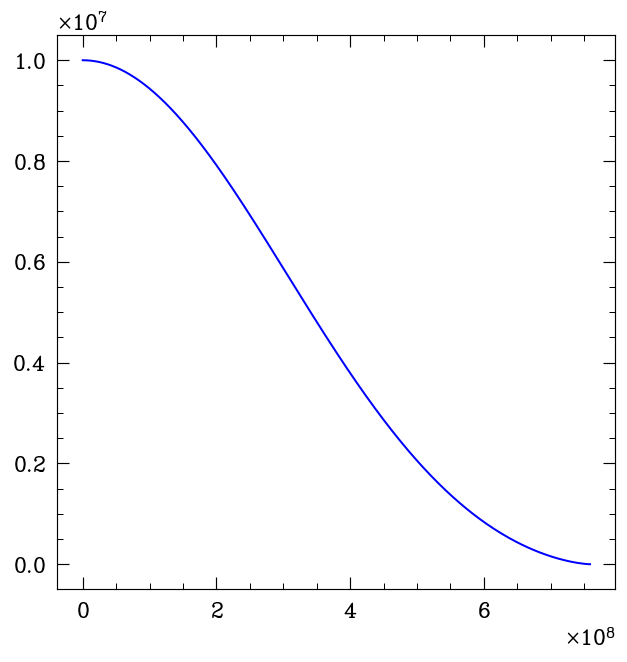

In [176]:
plt.plot(solution.t, solution.y[0], 'b', label='rho(r)')

Text(0, 0.5, '$\\rho/\\rho_0$ ')

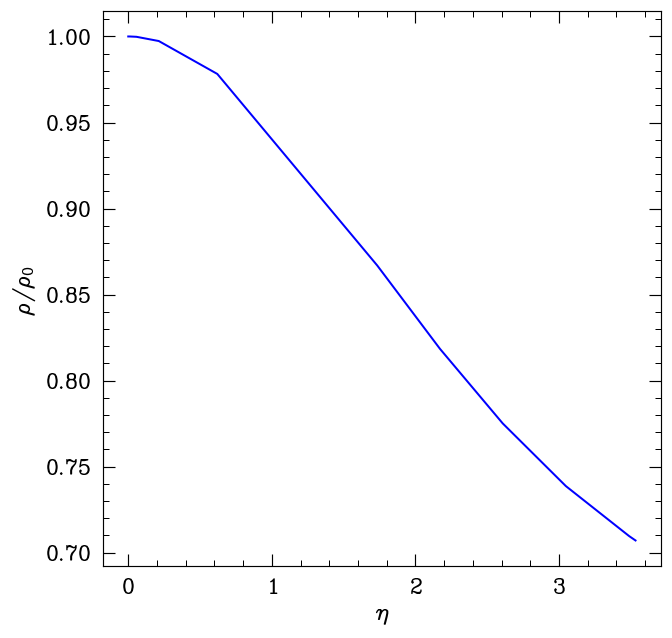

In [19]:
# Lets try and do it using Chandresekhar (general form of Lane-Emden) equation.

def Chand_system(eta, y, C):
    return np.array([y[1], -2/eta * y[1] - (y[0]**2-C)**(3/2)])


Chand_y0 = [1, 0]

# Chand_soln = solve_ivp(Chand_system, [0.001,1], Chand_y0, args=(0.5,), method = 'DOP853', t_eval=[0.001, 0.1, 0.5, 0.7, 1])
Chand_soln = solve_ivp(Chand_system, [0.000001,10], Chand_y0, args=(0.5,), method='DOP853', atol=1e-20)

plt.plot(Chand_soln.t, Chand_soln.y[0], 'b', label='rho(r)')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\rho/\rho_0$ ')


In [17]:
Chand_soln

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 1.000e-06  1.000e-06 ...  3.533e+00  3.533e+00]
        y: [[ 1.000e+00  1.000e+00 ...  7.071e-01  7.071e-01]
            [ 0.000e+00 -1.000e-17 ... -5.665e-02 -5.665e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1154
     njev: 0
      nlu: 0

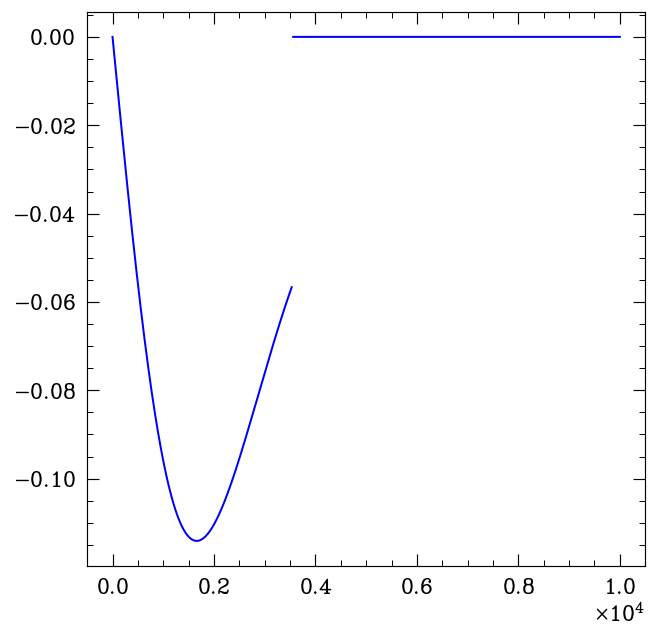

In [16]:

Chand_soln2 = odeint(Chand_system, Chand_y0, t=np.linspace(0.00001, 10, 10000), args=(0.5,), tfirst=True)

plt.plot(Chand_soln2[:, 1], 'b', label='rho(r)')

# New entry jason 10/10/23

## Chemical potential solve 

In [ ]:
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.optimize import brentq 
from scipy.integrate import odeint

In [ ]:
### Constants here beecuse its just easier
h = (c.h).cgs.value
cc = (c.c).cgs.value
k = (c.k_B).cgs.value
m = (c.m_e).cgs.value

def integrand(p, mu, T):
    return (p**2) / (np.exp((-mu + m * cc**2 * np.sqrt(1 + (p/(m*cc))**2)) / (k * T)) + 1)

def calculate_n(mu, T):
    result, _ = quad(integrand, 0, np.inf, args=(mu, T))
    # print(f"mu = {mu}, T = {T}, n = {n}")
    return (8 * np.pi) / (h**3) * result


def calculate_mu(n, T):
    def f(mu):
        return calculate_n(mu, T) - n
    
    result = root_scalar(f, bracket=[0, 1e10])

    if result.converged:
        mu = result.root
    else:
        # Handle the case where convergence fails, e.g., raise an exception
        raise ValueError("Failed to converge in calculate_mu")
    return mu
    

In [ ]:
ne_range = np.logspace(-1, 50, 10)
T = 1e7

# Solve for mu over the specified range
for ne in ne_range:
     mu = calculate_mu(ne, T)
     print(mu)

### solve the pressure as a function of density

In [ ]:
### Jason: Eric this is basically what you did but i was trying to use a calcuualted ne from the mu vlaue rather then strigth from a range of ne values

def Pmax(ne):
    return (3 * ne * h**3 / (8 * np.pi))**(1/3)

# Function for pressure in the non-relativistic regime
def pressure_NR(ne):
    return (h**2 / (60 * np.pi**(2/3) * m)) * (3 * ne)**(5/3)

# Function for pressure in the intermediate regime
def pressure_IR(ne):
    Pmax = Pmax(ne)
    y = Pmax / (m * cc)
    return (np.pi * m**4 * c**5 / (3 * h**3)) * (y * np.sqrt(1 + y**2) * (2 * y**2 - 3) + 3 * np.arcsinh(y))

# Function for pressure in the extremely relativistic regime
def pressure_ER(ne):
    return (cc * h / (24 * np.pi**(1/3))) * (3 * ne)**(4/3)


# solve for the n from the integral adn then use that to solve for the pressure
def pressure(ne):
     n = calculate_n(mu_solved, T)
    
     print(n)
     if Pmax(n) < 0.001 * m * cc:
         return pressure_NR(n)
     elif Pmax(n) > 100 * m * cc:
         return pressure_ER(n)
     else:
         return pressure_IR(n)


T = np.logspace(4, 8, 100)
for i in T:
    plt.plot(calculate_n(mu_solved, i))

plt.show()

## Something about the Lame-Emden equation

In [3]:
#set up function which can solve the lame emden equation for any value of 'n'.
def solve(n):
    """Solves the Lame-Emdem equation for any value of n.
    
    args: n
    """
    #create empty lists for theta and xi values to store them into
    theta_values = []
    xi_values = []
    
    #define values of xi, delta xi, the gradient and theta
    xi = 0.00001
    d_xi = 0.001
    dtheta = 0
    theta = 1
    
    #create a variable to store xi
    xi_now = xi
    
    #use while loop to find theta and xi values until theta=0
    while (theta >= 0) and (xi_now < 20):
        
        #increase xi value by small amount
        xi_now = xi_now + d_xi
    
        #calculate values after small increase in xi
        dtheta_next = dtheta - (((2/xi_now)*dtheta)+theta**n)*d_xi
        theta_next = theta + dtheta_next*d_xi

        #update the old values to be the new ones
        dtheta = dtheta_next
        theta  = theta_next
        
        #store these values in list
        theta_values.append(theta)
        xi_values.append(xi_now)
    
    #convert lists to arrays to make it easier to deal with
    xi_values = np.array(xi_values)
    theta_values = np.array(theta_values)
    return (xi_values, theta_values)

In [ ]:
#call the function to find the theata and xi values for each n
xi_0, theta_0 = solve(3/2)
xi_3, theta_3 = solve(3)

#plot the values of xi vs theta for each n value
fig, axis = plt.subplots(figsize = (9,5))
axis.plot(xi_0, theta_0, label = 'n = 3/2')
axis.plot(xi_3, theta_3, label = 'n = 3')

#set limits on the axes
axis.set_ylim(0)
axis.set_xlim(0, 20)
#give title and axes labels
# axis.set_title('Numerical Solutions to the Lame Emden Equation')
axis.set_ylabel('$\\rho / \\rho_0$')
axis.set_xlabel('$R / R_0$')
#add a legend
axis.legend()
#show
plt.show()